# Imports

In [1]:
# general
import torch
from tqdm.notebook import tqdm

# data
from torch.utils.data import DataLoader
from datasets import load_dataset

# visualization
import matplotlib.pyplot as plt
import seaborn as sns


# model
from transformers import AutoTokenizer, AutoModelForSequenceClassification, default_data_collator
from peft import LoraConfig, get_peft_model
from torch.nn.functional import cross_entropy
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# custom
from utils import * # custom py file

/home/g.fidone/hlt/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/g.fidone/hlt/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/g.fidone/hlt/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
# sns style
sns.set_theme(style="whitegrid", font='cmr10', font_scale=1.5)

# Reproducibility

In [3]:
SEED = 42
determinism = True
if determinism:
    set_deterministic_mode(SEED) # custom function (see utils.py)

# Data

In [4]:
train = load_dataset('json', data_files='subtaskA_train_sample.jsonl', split='train')
val = load_dataset('json', data_files='subtaskA_dev_monolingual.jsonl', split='train')
test = load_dataset('json', data_files='subtaskA_test.jsonl', split='train')

In [5]:
print(train.shape, val.shape, test.shape)

(53890, 5) (5000, 5) (11976, 5)


In [6]:
train

Dataset({
    features: ['text', 'label', 'model', 'source', 'id'],
    num_rows: 53890
})

In [7]:
val

Dataset({
    features: ['text', 'label', 'model', 'source', 'id'],
    num_rows: 5000
})

In [8]:
test

Dataset({
    features: ['text', 'label', 'model', 'source', 'id'],
    num_rows: 11976
})

In [9]:
model_tokenizer_path = 'FacebookAI/roberta-base' 

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer_path) # initializing tokenizer
if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

In [11]:
max_length = 143

In [12]:
train = train.map(
          lambda text: tokenizer(text['text'], 
                                 truncation=True,
                                 max_length=max_length, 
                                 padding=True,
                                 return_tensors='pt'), 
          batched=True,
          remove_columns=['id', 'text', 'source', 'model'],
          desc="Running tokenizer on dataset")

In [13]:
val = val.map(
          lambda text: tokenizer(text['text'], 
                                 truncation=True,
                                 max_length=max_length, 
                                 padding=True,
                                 return_tensors='pt'), 
          batched=True,
          remove_columns=['id', 'text', 'source', 'model'],
          desc="Running tokenizer on dataset")

In [14]:
test = test.map(
          lambda text: tokenizer(text['text'], 
                                 truncation=True,
                                 max_length=max_length, 
                                 padding=True,
                                 return_tensors='pt'), 
          batched=True,
          remove_columns=['id', 'text', 'source', 'model'],
          desc="Running tokenizer on dataset")

In [15]:
train

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 53890
})

In [16]:
val

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 5000
})

In [17]:
test

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 11976
})

In [18]:
batch_size = 32

In [19]:
def seed_worker(worker_id): # defining worker_init_fn for dataloader
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

In [20]:
train = DataLoader(
    train, 
    shuffle=True,
    collate_fn=default_data_collator, 
    batch_size=batch_size, 
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

In [21]:
val = DataLoader(
    val, 
    shuffle=False,
    collate_fn=default_data_collator, 
    batch_size=batch_size, 
    pin_memory=True
)

In [22]:
test = DataLoader(
    test, 
    shuffle=False,
    collate_fn=default_data_collator, 
    batch_size=batch_size, 
    pin_memory=True
)

# Model

In [23]:
model = AutoModelForSequenceClassification.from_pretrained(model_tokenizer_path, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# hyper-parameters

lr = 1e-6
weight_decay = 9e-1
r=8 
lora_alpha=16
lora_dropout=0.1

In [25]:
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=False, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066137476531099


In [26]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

In [27]:
check_cuda_memory() # custom function (see utils.py)

Current Tesla V100S-PCIE-32GB memory usage: 0.000/31.739 GiB


In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device);

In [29]:
check_cuda_memory()

Current Tesla V100S-PCIE-32GB memory usage: 0.469/31.739 GiB


## Training

In [30]:
num_epochs = 10
early_stopping = True

In [31]:
early_stopper = EarlyStopper(patience=2, delta=1e-2) # custom object (see utils.py)

train_losses = list()
val_losses = list()
train_accs = list()
val_accs = list()
train_f1s = list()
val_f1s = list()
    
# training loop

for epoch in range(num_epochs):
    model.train()
    train_loss = .0
    y_train = list()
    y_pred = list()
    for batch in tqdm(train, desc=f'Epoch {epoch}: training (TR)'):
        batch = {k: v.to(device) for k, v in batch.items()} # moving batches to gpu
        output = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        loss = cross_entropy(output.logits, batch['labels'])
        train_loss += loss.detach().cpu().item() # updating loss
        predictions = torch.argmax(output.logits, -1).cpu()
        y_pred.extend(predictions) # updating predictions
        y_train.extend([item.detach().cpu().item() for item in batch['labels']]) # updating true labels
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True) # set_to_none=True reduces memory footprint
        
    train_epoch_loss = train_loss / len(train) # epoch loss as mean loss over iterations (batches)
    train_acc = round(accuracy_score(y_train, y_pred), 3)
    train_f1 = round(f1_score(y_train, y_pred, average='macro'), 3)
    
    model.eval()
    val_loss = .0
    y_val = list()
    y_pred = list()
    for batch in tqdm(val, desc=f'Epoch {epoch}: inference (VL)'):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            output = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask']) 
        loss = cross_entropy(output.logits, batch['labels'])
        val_loss += loss.detach().cpu().item()
        predictions = torch.argmax(output.logits, -1).cpu()
        y_pred.extend(predictions)
        y_val.extend([item.detach().cpu().item() for item in batch['labels']])
        
    val_epoch_loss = val_loss / len(val)
    val_acc = round(accuracy_score(y_val, y_pred), 3)
    val_f1 = round(f1_score(y_val, y_pred, average='macro'), 3)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    print(f'Epoch {epoch}')
    print(f'TR Loss: {train_epoch_loss:12}\tVL Loss: {val_epoch_loss:12}')  # logging
    print(f'TR Accuracy: {train_acc:4}\t\tVL Accuracy: {val_acc:4}')
    print(f'TR F1: {train_f1:4}\t\t\tVL F1 (Macro): {val_f1:4}')
    
    if early_stopping:
        counter, stop = early_stopper(val_epoch_loss)
        if stop:
            torch.save(model.state_dict(), f'roberta_A_epoch_{epoch}.pth')
            print(f'Training early stopped at epoch {epoch}.')
            break
        if counter == 0:
            torch.save(model.state_dict(), f'roberta_A_epoch_{epoch}.pth') # saving model at optimal values of VL loss (before possible increase)

Epoch 0: training (TR):   0%|          | 0/1685 [00:00<?, ?it/s]

Epoch 0: inference (VL):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 0
TR Loss: 0.6888098602832602	VL Loss: 0.6874668389368969
TR Accuracy: 0.537		VL Accuracy:  0.5
TR F1: 0.433			VL F1 (Macro): 0.333


Epoch 1: training (TR):   0%|          | 0/1685 [00:00<?, ?it/s]

Epoch 1: inference (VL):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1
TR Loss: 0.6763950302975822	VL Loss: 0.6774310067201116
TR Accuracy: 0.588		VL Accuracy: 0.551
TR F1: 0.518			VL F1 (Macro): 0.461


Epoch 2: training (TR):   0%|          | 0/1685 [00:00<?, ?it/s]

Epoch 2: inference (VL):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2
TR Loss: 0.6503847718946304	VL Loss: 0.6583359150370215
TR Accuracy: 0.68		VL Accuracy: 0.671
TR F1: 0.652			VL F1 (Macro): 0.663


Epoch 3: training (TR):   0%|          | 0/1685 [00:00<?, ?it/s]

Epoch 3: inference (VL):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3
TR Loss: 0.5953419900435722	VL Loss: 0.6208319204628088
TR Accuracy: 0.766		VL Accuracy: 0.705
TR F1: 0.759			VL F1 (Macro): 0.705


Epoch 4: training (TR):   0%|          | 0/1685 [00:00<?, ?it/s]

Epoch 4: inference (VL):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4
TR Loss: 0.49438729112862834	VL Loss: 0.5777443348412301
TR Accuracy: 0.808		VL Accuracy: 0.72
TR F1: 0.806			VL F1 (Macro): 0.719


Epoch 5: training (TR):   0%|          | 0/1685 [00:00<?, ?it/s]

Epoch 5: inference (VL):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5
TR Loss: 0.38141986544655765	VL Loss: 0.6035561744882992
TR Accuracy: 0.843		VL Accuracy: 0.735
TR F1: 0.841			VL F1 (Macro): 0.733


Epoch 6: training (TR):   0%|          | 0/1685 [00:00<?, ?it/s]

Epoch 6: inference (VL):   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6
TR Loss: 0.3061225623467202	VL Loss: 0.612251506643785
TR Accuracy: 0.876		VL Accuracy: 0.755
TR F1: 0.875			VL F1 (Macro): 0.754
Training early stopped at epoch 6.


/tmp/ipykernel_308565/2378197003.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(train_losses, label='TR')


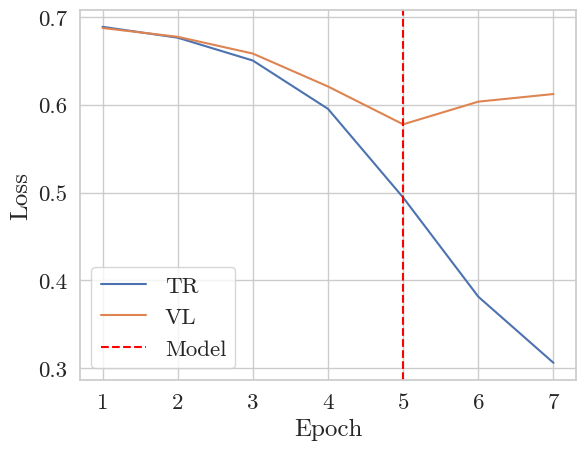

In [32]:
plt.plot(train_losses, label='TR')
plt.plot(val_losses, label='VL')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.axvline(x=4, color='red', linestyle='--', label='Model')
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7]) 
plt.legend()
plt.savefig('learning_curves_A_roberta.png', bbox_inches="tight")
plt.show()

/tmp/ipykernel_308565/6319539.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(train_accs, label='TR')


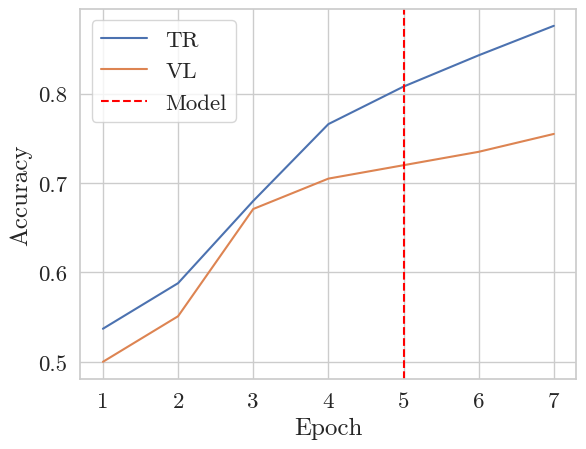

In [33]:
plt.plot(train_accs, label='TR')
plt.plot(val_accs, label='VL')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.axvline(x=4, color='red', linestyle='--', label='Model')
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7]) 
plt.legend()
plt.savefig('accs_A_roberta.png', bbox_inches="tight")
plt.show()

/tmp/ipykernel_308565/3731932009.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.plot(train_f1s, label='TR')


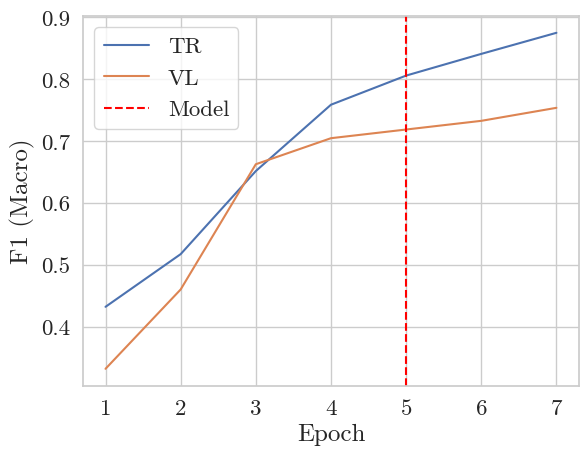

In [34]:
plt.plot(train_f1s, label='TR')
plt.plot(val_f1s, label='VL')
plt.xlabel('Epoch')
plt.ylabel('F1 (Macro)')
plt.axvline(x=4, color='red', linestyle='--', label='Model')
plt.xticks([0, 1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6, 7]) 
plt.legend()
plt.savefig('f1s_A_roberta.png', bbox_inches="tight")
plt.show()

# Testing

In [35]:
model_tokenizer_path = 'FacebookAI/roberta-base'

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(model_tokenizer_path, num_labels=2)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
trained_parameters = 'roberta_A_epoch_4.pth' # file pth with model at epoch 4
peft_config = LoraConfig(task_type="SEQ_CLS", inference_mode=True, r=8, lora_alpha=16, lora_dropout=0.1)
model = get_peft_model(model, peft_config)
model.load_state_dict(torch.load(trained_parameters)) 

<All keys matched successfully>

In [38]:
check_cuda_memory() 

Current Tesla V100S-PCIE-32GB memory usage: 0.491/31.739 GiB


In [39]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device);

In [40]:
check_cuda_memory()

Current Tesla V100S-PCIE-32GB memory usage: 0.972/31.739 GiB


In [45]:
y_pred = list()
y_test = list()
for batch in tqdm(test):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            output = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        predictions = torch.argmax(output.logits, -1).cpu()
        y_pred.extend(predictions)
        y_test.extend([item.detach().cpu().item() for item in batch['labels']]) # updating true labels

  0%|          | 0/375 [00:00<?, ?it/s]

In [46]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.949     0.652     0.773      6298
           1      0.713     0.961     0.819      5678

    accuracy                          0.798     11976
   macro avg      0.831     0.806     0.796     11976
weighted avg      0.837     0.798     0.795     11976



/home/g.fidone/hlt/lib/python3.10/site-packages/seaborn/matrix.py:456: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  ax = plt.gca()
/home/g.fidone/hlt/lib/python3.10/site-packages/seaborn/matrix.py:316: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cb = ax.figure.colorbar(mesh, cax, ax, **self.cbar_kws)


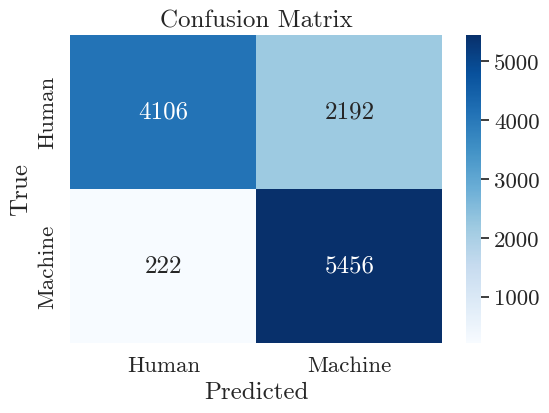

In [47]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Human', 'Machine'], yticklabels=['Human', 'Machine'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_A_roberta.png', bbox_inches="tight")
plt.show()